In [1]:
import numpy as np  
from tqdm.auto import tqdm, trange  
import matplotlib.pyplot as plt
import torch 
import torchvision
from torchvision import transforms, datasets

In [2]:
training = datasets.MNIST('', train=True, download=True, 
                       transform=transforms.Compose([transforms.ToTensor()]))

testing = datasets.MNIST('', train=False, download=True, 
                       transform=transforms.Compose([transforms.ToTensor()]))

trainSet = torch.utils.data.DataLoader(training, batch_size=64, shuffle=True)
testSet = torch.utils.data.DataLoader(testing, batch_size=64, shuffle=True)

In [3]:
for data in trainSet:
    break

In [ ]:
print(len(data), len(data[0]))
print(data)
# We can see that the dataloader sets us up with a list of 2, each list is 64 long with corresponding images and labels.

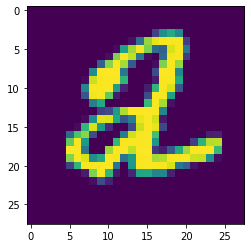

tensor(2)


In [4]:
showDig , showLab = data[0][0], data[1][0]

plt.imshow(showDig.view(28,28))
plt.show()
print(showLab)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        
        x = torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512,10)
    
    def convs(self, x):
        print(x.size())
        x = F.relu(self.conv1(x))
        print(x.size())
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        print(x.size())
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        print(x.size())
        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))
        print(x.size())
       
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]* x[0].shape[1]* x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()             
print(net)

torch.Size([1, 1, 28, 28])
torch.Size([1, 32, 26, 26])
torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 5, 5])
torch.Size([1, 128, 1, 1])
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [7]:
import torch.optim as optim

In [8]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def fwd_pass(data, train=False):
    correct = 0 
    total = 0
    
    if train:
        net.zero_grad()

    X, y = data
    batch_X = X.view(-1, 1, 28, 28)
    output = net(batch_X)
    batch_y = []
    for i in range(len(y)):
        list = [float(0)]*10
        list[int(y[i])] = 1
        batch_y.append(list)
    
    newY = torch.tensor(batch_y)
    loss = loss_function(output, newY)
    
    for i in range(len(batch_y)):
        # print(torch.argmax(torch.tensor(batch_y[i])).item(),torch.argmax(torch.tensor(output[i])).item())
        if torch.argmax(torch.tensor(batch_y[i])).item() == torch.argmax(torch.tensor(output[i])).item():
            correct += 1
        total +=1

    acc = correct/total

    if train:
        loss.backward()
        optimizer.step()

    # print(acc, loss.item())
    return acc, loss.item()


In [9]:
import time

MODEL_NAME = f"model-{int(time.time())}"
print(MODEL_NAME)

def test():
    counting = 0
    acc = 0
    loss = 0
    with torch.no_grad():
        for data in tqdm(testSet, desc="Testing Batch Progress"):
            accTemp, lossTemp = fwd_pass(data)
            acc += accTemp
            counting += 1
            loss += lossTemp
        
        print(acc/counting, loss/counting)
        return acc/counting, loss/counting 

        


model-1611174083


In [10]:
EPOCHS = 5
counter = 0

with open("MNISTDATA.log", "a") as f:
    for epoch in tqdm(range(EPOCHS), desc="Epochs Progress"):
        for data in tqdm(trainSet, desc="Data Batch Progress"):
            counter += 1
            acc, loss = fwd_pass(data, train=True)

            if counter == 140:
                counter = 0
                val_acc, val_loss = test()
                f.write(f"{MODEL_NAME},{round(time.time(),4)},{round(float(acc),4)},{round(float(loss),4)},{round(float(val_acc),4)},{round(float(val_loss),4)}\n")
    

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


<ipython-input-8-a09c4b72f60f>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.argmax(torch.tensor(batch_y[i])).item() == torch.argmax(torch.tensor(output[i])).item():
C:\Users\asrock\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])


torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([6

torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([6

torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 32, 26, 26])
torch.Size([64, 64, 12, 12])
torch.Size([64, 64, 5, 5])
torch.Size([64, 128, 1, 1])
torch.Size([6

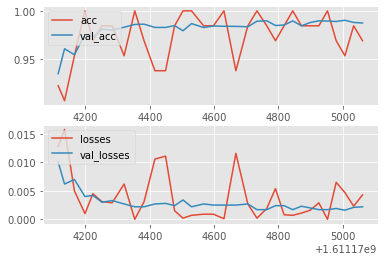

In [12]:
from  matplotlib import style

style.use("ggplot")

model_name = 'model-1611174083'

def create_acc_loss_graph(model_name):
    contents = open('MNISTDATA.log', 'r').read().split('\n')

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(',')

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

        
    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

    ax1.plot(times, accuracies, label='acc')
    ax1.plot(times, val_accs, label='val_acc')
    ax1.legend(loc=2)

    ax2.plot(times, losses, label='losses')
    ax2.plot(times, val_losses, label='val_losses')
    ax2.legend(loc=2)

    plt.show()

create_acc_loss_graph(model_name)